### 🧩 Workflow Overview of `ortools.sat.python.cp_model` (CP-SAT Solver)

The **`ortools.sat.python.cp_model`** module provides a high-level interface to model and solve **Constraint Programming (CP)** problems using Google's **CP-SAT** solver, which is designed for **combinatorial optimization** problems. The standard workflow begins by instantiating a `CpModel` object, which acts as the container for **variables**, **constraints**, and the **objective function**. You define decision variables using functions like `NewIntVar`, `NewBoolVar`, or `NewIntervalVar`, depending on whether you're modeling integer values, booleans, or time intervals respectively. Constraints are added via methods such as `Add`, `AddLinearConstraint`, `AddNoOverlap`, and `AddMaxEquality`, among others. You can also model logical conditions using `OnlyEnforceIf` tied to boolean variables, allowing the inclusion of **optional or conditional constraints**. Once the model is constructed, it's passed to a `CpSolver` instance via `solver.Solve(model)`, which attempts to find a solution that satisfies all constraints and optionally optimizes an objective via `model.Minimize(...)` or `model.Maximize(...)`.

🛑 **Caution Points:**
- **All variables must be bounded**—the solver needs finite ranges to work correctly.
- **Optional intervals require boolean literals** to activate/deactivate them conditionally.
- When using `OnlyEnforceIf`, ensure the condition is logically tight (i.e., not under-constrained).
- Watch for **variable reuse** across conflicting constraints—it can silently lead to unsatisfiable models.
- Use `solver.Value(var)` only *after* a successful solve status (`OPTIMAL` or `FEASIBLE`).
- **Debugging** is easier when variable names are informative and logs (`solver.parameters.log_search_progress = True`) are enabled during development.

This modular structure—model definition, variable creation, constraint composition, objective setup, and solver invocation—makes CP-SAT both expressive and scalable for a wide range of scheduling, packing, routing, and allocation problems.

---

### ✅ Step-by-Step Guide to Using `cp_model` (OR-Tools CP-SAT Solver)

1. **Import the OR-Tools module:**
   ```python
   from ortools.sat.python import cp_model
   ```

2. **Create a model instance:**
   - This acts as the container for all variables, constraints, and objectives.
   ```python
   model = cp_model.CpModel()
   ```

3. **Define decision variables:**
   - Use bounded integer or boolean variables depending on the problem.
   - Example:
     ```python
     x = model.NewIntVar(0, 10, 'x')          # Integer variable from 0 to 10
     y = model.NewBoolVar('y')                # Boolean variable (0 or 1)
     ```

4. **(Optional) Define interval or optional interval variables:**
   - For scheduling problems, use:
     ```python
     interval = model.NewIntervalVar(start, duration, end, 'task1')
     optional_interval = model.NewOptionalIntervalVar(start, duration, end, is_present, 'task1_optional')
     ```

5. **Add constraints to the model:**
   - Use `.Add()` for linear or logical constraints.
   - Chain with `.OnlyEnforceIf(bool_var)` for conditional constraints.
     ```python
     model.Add(x + y <= 5)
     model.Add(x > 3).OnlyEnforceIf(y)
     ```

6. **(Optional) Add special constraints:**
   - Use high-level constraints like:
     ```python
     model.AddAllDifferent([x1, x2, x3])
     model.AddNoOverlap([interval1, interval2, interval3])
     model.AddMaxEquality(max_var, [a, b, c])
     ```

7. **Define the objective (if optimizing):**
   - Use `model.Minimize(...)` or `model.Maximize(...)`.
     ```python
     model.Minimize(x + y)
     ```

8. **Create a solver and solve the model:**
   ```python
   solver = cp_model.CpSolver()
   status = solver.Solve(model)
   ```

9. **Check solver status:**
   - Verify that a solution exists:
     ```python
     if status in [cp_model.OPTIMAL, cp_model.FEASIBLE]:
         print("Solution found.")
     else:
         raise RuntimeError("No feasible solution.")
     ```

10. **Extract solution values:**
    - Use `solver.Value(variable)` to get concrete values.
      ```python
      print("x =", solver.Value(x))
      ```

11. **(Optional) Visualize or analyze results:**
    - Useful for scheduling problems (e.g., Gantt charts), resource allocation, etc.

12. **(Optional) Set solver parameters (e.g., time limits, logging):**
    ```python
    solver.parameters.max_time_in_seconds = 10.0
    solver.parameters.log_search_progress = True
    ```

---


In [12]:
import matplotlib.pyplot as plt
from ortools.sat.python import cp_model

def schedule_tasks_ortools(tasks, n_bins, show_gantt=True):
    """
    Schedule a set of tasks with precedence constraints across multiple bins
    (e.g., workers or machines) to minimize the overall makespan using OR-Tools CP-SAT solver.

    Args:
        tasks (dict): Dictionary where each key is a task ID (any hashable identifier), and
                      the value is another dict with keys:
                        - 'tasktime': int, duration of the task
                        - 'prerequisites': list of task IDs that must finish before this task starts
        n_bins (int): Number of parallel bins (machines, workers, processors).
        show_gantt (bool): If True, display a Gantt chart of the resulting schedule.

    Returns:
        bins (list of lists): List where each element is a list of task IDs assigned to that bin.
        makespan (int): The minimized total time to complete all tasks (maximum of end times).
    
    Raises:
        RuntimeError: If no feasible or optimal schedule is found.

    Example:
        tasks = {
            'A': {'tasktime': 3, 'prerequisites': []},
            'B': {'tasktime': 2, 'prerequisites': ['A']},
            'C': {'tasktime': 4, 'prerequisites': ['A']},
        }
        schedule_tasks_ortools(tasks, n_bins=2)
    """

    model = cp_model.CpModel()
    task_ids = list(tasks.keys())
    task_index = {t: i for i, t in enumerate(task_ids)}  # Mapping task ID to index
    tasktime = [tasks[t]['tasktime'] for t in task_ids]
    horizon = sum(tasktime)  # Maximum possible time to bound variables

    # Create variables
    start_vars, end_vars, bin_vars = [], [], []
    optional_intervals_per_bin = [[] for _ in range(n_bins)]
    
    # Set model variables
    for i, t in enumerate(task_ids):
        duration = tasktime[i]

        # Start and end time for each task
        start = model.NewIntVar(0, horizon, f'start_{t}')
        end = model.NewIntVar(0, horizon, f'end_{t}')
        start_vars.append(start)
        end_vars.append(end)

        # Bin assignment variable for this task
        bin_var = model.NewIntVar(0, n_bins - 1, f'bin_{t}')
        bin_vars.append(bin_var)

        # For each bin, define an optional interval that is only active if the task is assigned to that bin
        for b in range(n_bins):
            is_on_bin = model.NewBoolVar(f'is_{t}_on_bin_{b}')
            # Enforce bin assignment logic via boolean control variable
            model.Add(bin_var == b).OnlyEnforceIf(is_on_bin)
            model.Add(bin_var != b).OnlyEnforceIf(is_on_bin.Not())

            # Optional interval: present only if is_on_bin is true
            interval = model.NewOptionalIntervalVar(start, duration, end, is_on_bin, f'interval_{t}_bin_{b}')
            optional_intervals_per_bin[b].append(interval)

    # Enforce non-overlapping tasks on the same bin
    for b in range(n_bins):
        model.AddNoOverlap(optional_intervals_per_bin[b])

    # Enforce precedence constraints
    for t in task_ids:
        i = task_index[t]
        prereq_end = [end_vars[task_index[p]] for p in tasks[t]['prerequisites']]
        if prereq_end:
            # Define a variable for the latest end time among all prerequisites
            prereq_max = model.NewIntVar(0, horizon, f'prereq_max_{t}')
            model.AddMaxEquality(prereq_max, prereq_end)
            # Start of current task must be after all its prerequisites end
            model.Add(start_vars[i] >= prereq_max)

    # Objective: minimize makespan = max(end_times of all tasks)
    makespan = model.NewIntVar(0, horizon, 'makespan')
    model.AddMaxEquality(makespan, end_vars)
    model.Minimize(makespan)

    # Solve the model
    solver = cp_model.CpSolver()
    status = solver.Solve(model)

    if status not in [cp_model.OPTIMAL, cp_model.FEASIBLE]:
        raise RuntimeError("No feasible solution found.")

    # Collect and display schedule
    schedule = []
    for i, t in enumerate(task_ids):
        b = solver.Value(bin_vars[i])
        s = solver.Value(start_vars[i])
        e = solver.Value(end_vars[i])
        schedule.append({'task': t, 'bin': b, 'start': s, 'end': e})

    # Sort by bin then by start time within each bin
    schedule.sort(key=lambda x: (x['bin'], x['start']))

    print("Task Schedule:")
    for item in schedule:
        print(f"Task {item['task']:>2} | Bin {item['bin']} | Start: {item['start']:>2} | End: {item['end']:>2}")

    # Optional: Display a Gantt chart
    if show_gantt:
        fig, ax = plt.subplots(figsize=(10, 0.6 * n_bins + 1))
        colors = plt.cm.tab10.colors  # Use 10-cycle color palette

        for item in schedule:
            ax.barh(item['bin'], item['end'] - item['start'], left=item['start'],
                    color=colors[task_index[item['task']] % len(colors)], edgecolor='black')
            ax.text(item['start'] + 0.1, item['bin'] + 0.1, item['task'],
                    va='center', ha='left', fontsize=9)

        ax.set_yticks(range(n_bins))
        ax.set_yticklabels([f"Bin {i}" for i in range(n_bins)])
        ax.set_xlabel("Time")
        ax.set_title("Gantt Chart of Task Schedule")
        ax.grid(True, axis='x', linestyle='--', alpha=0.5)
        plt.tight_layout()
        plt.show()

    # Return a summary: list of tasks per bin and the final makespan
    bins = [[] for _ in range(n_bins)]
    for item in schedule:
        bins[item['bin']].append(item['task'])

    return bins, solver.ObjectiveValue()


# Simple Case

Task Schedule:
Task  B | Bin 0 | Start:  3 | End:  5
Task  A | Bin 1 | Start:  0 | End:  3
Task  C | Bin 1 | Start:  3 | End:  7
Task  D | Bin 1 | Start:  7 | End:  8


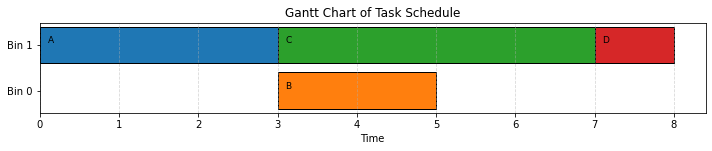

Schedule per bin: [['B'], ['A', 'C', 'D']]
Minimum makespan: 8.0


In [10]:
tasks = {
    'A': {'tasktime': 3, 'prerequisites': []},
    'B': {'tasktime': 2, 'prerequisites': ['A']},
    'C': {'tasktime': 4, 'prerequisites': ['A']},
    'D': {'tasktime': 1, 'prerequisites': ['B', 'C']}
}

bins, min_makespan = schedule_tasks_ortools(tasks, n_bins=2)
print("Schedule per bin:", bins)
print("Minimum makespan:", min_makespan)


# Complicated case : compare number of bins:
## 8 bins

Task Schedule:
Task T13 | Bin 0 | Start:  0 | End:  2
Task T17 | Bin 0 | Start:  3 | End: 13
Task T20 | Bin 0 | Start: 13 | End: 17
Task T5 | Bin 1 | Start:  0 | End:  3
Task T3 | Bin 1 | Start:  3 | End:  7
Task T11 | Bin 2 | Start:  0 | End:  1
Task T27 | Bin 2 | Start:  1 | End:  2
Task T14 | Bin 2 | Start:  2 | End:  6
Task T28 | Bin 2 | Start: 10 | End: 13
Task T10 | Bin 3 | Start:  0 | End:  7
Task T9 | Bin 3 | Start:  7 | End: 17
Task T15 | Bin 4 | Start:  0 | End:  4
Task T26 | Bin 4 | Start:  9 | End: 14
Task T25 | Bin 5 | Start:  0 | End: 10
Task T19 | Bin 6 | Start:  0 | End:  9
Task T18 | Bin 6 | Start:  9 | End: 10
Task T16 | Bin 6 | Start: 16 | End: 25
Task T2 | Bin 7 | Start:  0 | End:  5
Task T7 | Bin 7 | Start:  7 | End: 16
Task T24 | Bin 7 | Start: 16 | End: 24
Task T4 | Bin 8 | Start:  0 | End:  4
Task T12 | Bin 8 | Start:  4 | End:  5
Task T6 | Bin 8 | Start:  5 | End:  7
Task T8 | Bin 8 | Start:  7 | End:  9
Task T22 | Bin 8 | Start: 17 | End: 24
Task T0 | Bin 9 | 

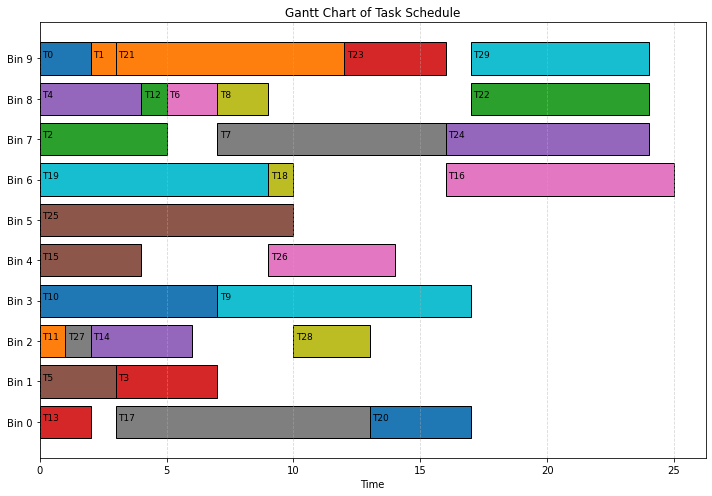

Schedule per bin: [['T13', 'T17', 'T20'], ['T5', 'T3'], ['T11', 'T27', 'T14', 'T28'], ['T10', 'T9'], ['T15', 'T26'], ['T25'], ['T19', 'T18', 'T16'], ['T2', 'T7', 'T24'], ['T4', 'T12', 'T6', 'T8', 'T22'], ['T0', 'T1', 'T21', 'T23', 'T29']]
Minimum makespan: 25.0


In [17]:
tasks = {
 'T0':  {'tasktime': 2,  'prerequisites': []},
 'T1':  {'tasktime': 1,  'prerequisites': ['T0']},
 'T2':  {'tasktime': 5,  'prerequisites': []},
 'T3':  {'tasktime': 4,  'prerequisites': ['T1']},
 'T4':  {'tasktime': 4,  'prerequisites': []},
 'T5':  {'tasktime': 3,  'prerequisites': []},
 'T6':  {'tasktime': 2,  'prerequisites': ['T0', 'T2', 'T4']},
 'T7':  {'tasktime': 9,  'prerequisites': ['T6', 'T0']},
 'T8':  {'tasktime': 2,  'prerequisites': ['T1', 'T3', 'T0']},
 'T9':  {'tasktime': 10, 'prerequisites': ['T5', 'T3']},
 'T10': {'tasktime': 7,  'prerequisites': []},
 'T11': {'tasktime': 1,  'prerequisites': []},
 'T12': {'tasktime': 1,  'prerequisites': ['T4']},
 'T13': {'tasktime': 2,  'prerequisites': []},
 'T14': {'tasktime': 4,  'prerequisites': ['T13']},
 'T15': {'tasktime': 4,  'prerequisites': []},
 'T16': {'tasktime': 9,  'prerequisites': ['T8', 'T7', 'T10']},
 'T17': {'tasktime': 10, 'prerequisites': ['T5', 'T11']},
 'T18': {'tasktime': 1,  'prerequisites': ['T6', 'T8']},
 'T19': {'tasktime': 9,  'prerequisites': []},
 'T20': {'tasktime': 4,  'prerequisites': ['T17']},
 'T21': {'tasktime': 9,  'prerequisites': ['T5']},
 'T22': {'tasktime': 7,  'prerequisites': ['T12', 'T8', 'T20']},
 'T23': {'tasktime': 4,  'prerequisites': ['T21']},
 'T24': {'tasktime': 8,  'prerequisites': ['T1', 'T7']},
 'T25': {'tasktime': 10, 'prerequisites': []},
 'T26': {'tasktime': 5,  'prerequisites': ['T12', 'T8']},
 'T27': {'tasktime': 1,  'prerequisites': []},
 'T28': {'tasktime': 3,  'prerequisites': ['T18']},
 'T29': {'tasktime': 7,  'prerequisites': ['T6', 'T20']}
}


# case : 10
bins, min_makespan = schedule_tasks_ortools(tasks, n_bins=10)
print("Schedule per bin:", bins)
print("Minimum makespan:", min_makespan)

In [21]:
## 6 bins

Task Schedule:
Task T25 | Bin 0 | Start:  0 | End: 10
Task T8 | Bin 0 | Start: 10 | End: 12
Task T14 | Bin 0 | Start: 12 | End: 16
Task T16 | Bin 0 | Start: 16 | End: 25
Task T11 | Bin 1 | Start:  0 | End:  1
Task T4 | Bin 1 | Start:  1 | End:  5
Task T1 | Bin 1 | Start:  5 | End:  6
Task T10 | Bin 1 | Start:  6 | End: 13
Task T26 | Bin 1 | Start: 13 | End: 18
Task T15 | Bin 1 | Start: 18 | End: 22
Task T28 | Bin 1 | Start: 22 | End: 25
Task T2 | Bin 2 | Start:  0 | End:  5
Task T27 | Bin 2 | Start:  5 | End:  6
Task T3 | Bin 2 | Start:  6 | End: 10
Task T12 | Bin 2 | Start: 10 | End: 11
Task T9 | Bin 2 | Start: 11 | End: 21
Task T23 | Bin 2 | Start: 21 | End: 25
Task T19 | Bin 3 | Start:  0 | End:  9
Task T21 | Bin 3 | Start:  9 | End: 18
Task T29 | Bin 3 | Start: 18 | End: 25
Task T5 | Bin 4 | Start:  0 | End:  3
Task T17 | Bin 4 | Start:  3 | End: 13
Task T20 | Bin 4 | Start: 13 | End: 17
Task T22 | Bin 4 | Start: 17 | End: 24
Task T0 | Bin 5 | Start:  0 | End:  2
Task T13 | Bin 5 |

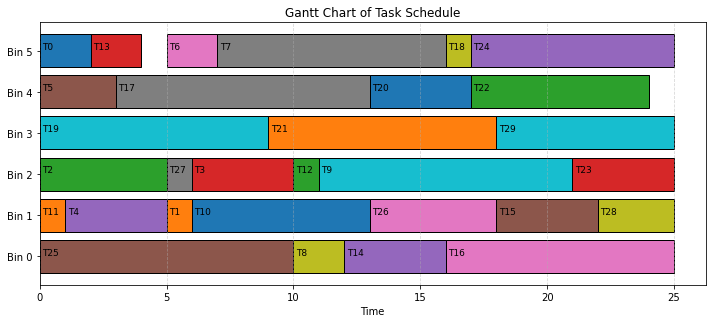

Schedule per bin: [['T25', 'T8', 'T14', 'T16'], ['T11', 'T4', 'T1', 'T10', 'T26', 'T15', 'T28'], ['T2', 'T27', 'T3', 'T12', 'T9', 'T23'], ['T19', 'T21', 'T29'], ['T5', 'T17', 'T20', 'T22'], ['T0', 'T13', 'T6', 'T7', 'T18', 'T24']]
Minimum makespan: 25.0


In [22]:
# case : 6
bins, min_makespan = schedule_tasks_ortools(tasks, n_bins=6)
print("Schedule per bin:", bins)
print("Minimum makespan:", min_makespan)

## 5 bins

Task Schedule:
Task T2 | Bin 0 | Start:  0 | End:  5
Task T21 | Bin 0 | Start:  5 | End: 14
Task T9 | Bin 0 | Start: 14 | End: 24
Task T18 | Bin 0 | Start: 24 | End: 25
Task T15 | Bin 0 | Start: 25 | End: 29
Task T10 | Bin 1 | Start:  0 | End:  7
Task T1 | Bin 1 | Start:  7 | End:  8
Task T7 | Bin 1 | Start:  8 | End: 17
Task T24 | Bin 1 | Start: 17 | End: 25
Task T14 | Bin 1 | Start: 25 | End: 29
Task T27 | Bin 1 | Start: 29 | End: 30
Task T5 | Bin 2 | Start:  0 | End:  3
Task T17 | Bin 2 | Start:  3 | End: 13
Task T20 | Bin 2 | Start: 13 | End: 17
Task T29 | Bin 2 | Start: 17 | End: 24
Task T26 | Bin 2 | Start: 24 | End: 29
Task T11 | Bin 3 | Start:  0 | End:  1
Task T25 | Bin 3 | Start:  1 | End: 11
Task T19 | Bin 3 | Start: 11 | End: 20
Task T22 | Bin 3 | Start: 20 | End: 27
Task T28 | Bin 3 | Start: 27 | End: 30
Task T4 | Bin 4 | Start:  0 | End:  4
Task T0 | Bin 4 | Start:  4 | End:  6
Task T6 | Bin 4 | Start:  6 | End:  8
Task T3 | Bin 4 | Start:  8 | End: 12
Task T8 | Bin 4 | S

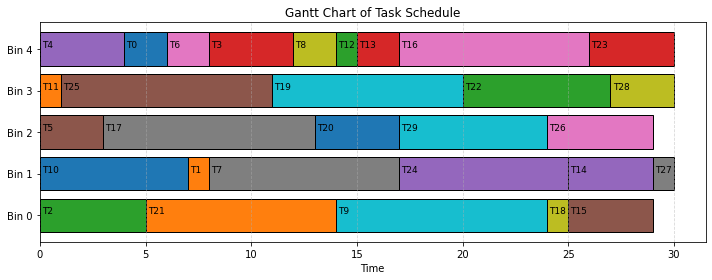

Schedule per bin: [['T2', 'T21', 'T9', 'T18', 'T15'], ['T10', 'T1', 'T7', 'T24', 'T14', 'T27'], ['T5', 'T17', 'T20', 'T29', 'T26'], ['T11', 'T25', 'T19', 'T22', 'T28'], ['T4', 'T0', 'T6', 'T3', 'T8', 'T12', 'T13', 'T16', 'T23']]
Minimum makespan: 30.0


In [23]:
# case : 5
bins, min_makespan = schedule_tasks_ortools(tasks, n_bins=5)
print("Schedule per bin:", bins)
print("Minimum makespan:", min_makespan)

## 4 bins

Task Schedule:
Task T11 | Bin 0 | Start:  0 | End:  1
Task T10 | Bin 0 | Start:  1 | End:  8
Task T21 | Bin 0 | Start:  8 | End: 17
Task T19 | Bin 0 | Start: 17 | End: 26
Task T22 | Bin 0 | Start: 26 | End: 33
Task T14 | Bin 0 | Start: 33 | End: 37
Task T2 | Bin 1 | Start:  0 | End:  5
Task T1 | Bin 1 | Start:  5 | End:  6
Task T3 | Bin 1 | Start:  6 | End: 10
Task T8 | Bin 1 | Start: 10 | End: 12
Task T9 | Bin 1 | Start: 12 | End: 22
Task T12 | Bin 1 | Start: 22 | End: 23
Task T24 | Bin 1 | Start: 23 | End: 31
Task T18 | Bin 1 | Start: 31 | End: 32
Task T15 | Bin 1 | Start: 32 | End: 36
Task T27 | Bin 1 | Start: 36 | End: 37
Task T4 | Bin 2 | Start:  0 | End:  4
Task T17 | Bin 2 | Start:  4 | End: 14
Task T20 | Bin 2 | Start: 14 | End: 18
Task T16 | Bin 2 | Start: 18 | End: 27
Task T13 | Bin 2 | Start: 27 | End: 29
Task T26 | Bin 2 | Start: 29 | End: 34
Task T28 | Bin 2 | Start: 34 | End: 37
Task T5 | Bin 3 | Start:  0 | End:  3
Task T0 | Bin 3 | Start:  3 | End:  5
Task T6 | Bin 3 | 

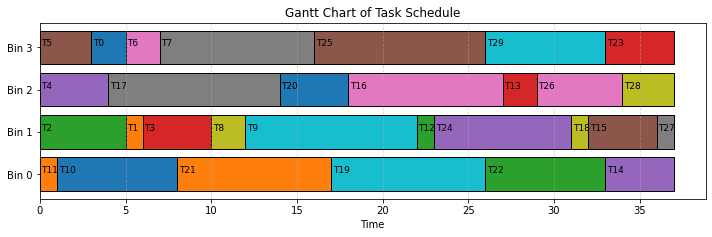

Schedule per bin: [['T11', 'T10', 'T21', 'T19', 'T22', 'T14'], ['T2', 'T1', 'T3', 'T8', 'T9', 'T12', 'T24', 'T18', 'T15', 'T27'], ['T4', 'T17', 'T20', 'T16', 'T13', 'T26', 'T28'], ['T5', 'T0', 'T6', 'T7', 'T25', 'T29', 'T23']]
Minimum makespan: 37.0


In [24]:
# case : 4
bins, min_makespan = schedule_tasks_ortools(tasks, n_bins=4)
print("Schedule per bin:", bins)
print("Minimum makespan:", min_makespan)